A. Chargement des données

In [35]:
import pandas as pd
df = pd.read_csv('../data/creditcard_clean.csv')

B. Préparation des données pour la modélisation

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

C. Gérer le déséquilibre de classes

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

D. Teste avec XGBClassifier

In [41]:
# XGBoost
from xgboost import XGBClassifier

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)

E. Fit, prédiction, évaluation avec XGBoost 

In [43]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('AUPRC:', average_precision_score(y_test, y_proba))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9682378578893572
AUPRC: 0.8800038893818777
Confusion matrix:
 [[56853    11]
 [   16    82]]


F. Prédire et évaluer les résultats
    Prédictions sur le test set
    Calcul des métriques : précision, rappel, F1-score, AUC ROC, AUPRC (area under precision-recall curve)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('AUPRC:', average_precision_score(y_test, y_proba))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.952908497036969
AUPRC: 0.8541999432510914
Confusion matrix:
 [[56861     3]
 [   25    73]]


G. Prédire et évaluer les résultats
    Courbe Precision-Recall (AUPRC)

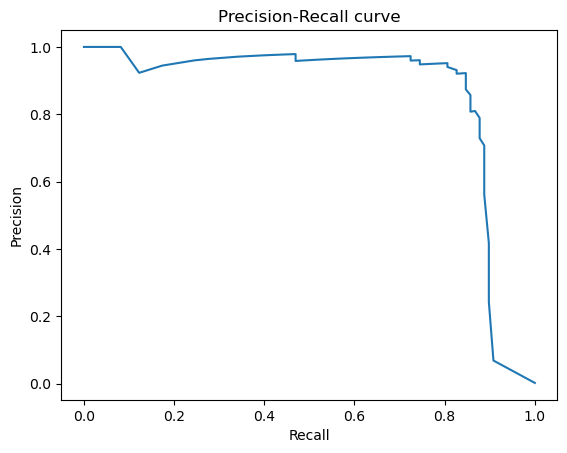

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.title("Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

H. Sauvegarde du modèle du randomforest

In [47]:
import joblib
joblib.dump(clf, '../models/randomforest_fraude.pkl')

['../models/randomforest_fraude.pkl']

I. Optimisation des hyperparamètres

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring='average_precision', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 7, 'n_estimators': 200}


J. Ajustement du seuil de décision

In [52]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    y_pred_custom = (y_proba >= t).astype(int)
    print(f"Threshold {t:.2f}: F1-score = {f1_score(y_test, y_pred_custom):.3f}")

Threshold 0.10: F1-score = 0.804
Threshold 0.15: F1-score = 0.844
Threshold 0.20: F1-score = 0.860
Threshold 0.25: F1-score = 0.883
Threshold 0.30: F1-score = 0.871
Threshold 0.35: F1-score = 0.868
Threshold 0.40: F1-score = 0.873
Threshold 0.45: F1-score = 0.847
Threshold 0.50: F1-score = 0.839
Threshold 0.55: F1-score = 0.826
Threshold 0.60: F1-score = 0.830
Threshold 0.65: F1-score = 0.817
Threshold 0.70: F1-score = 0.788
Threshold 0.75: F1-score = 0.734
Threshold 0.80: F1-score = 0.726
Threshold 0.85: F1-score = 0.693


K. Gestion avancée du déséquilibre

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

L. Validation croisée stratifiée

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y, cv=skf, scoring='average_precision')
print("AUPRC en validation croisée :", scores.mean())

AUPRC en validation croisée : 0.8586057941052152


M. Analyse de l’importance des variables (feature importance)

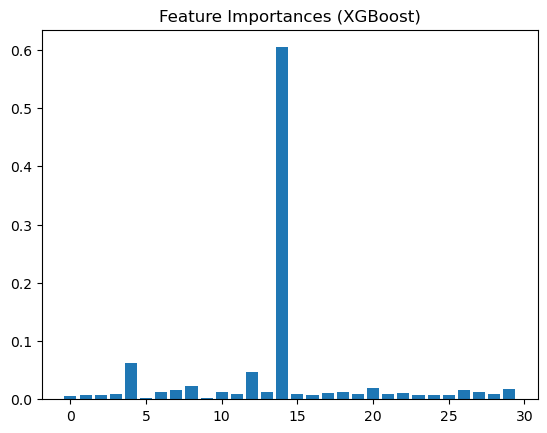

In [55]:
import matplotlib.pyplot as plt

importances = xgb.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances (XGBoost)")
plt.show()

O.Sauvegarde du modèle XGboost

In [63]:
import joblib

# Sauvegarde du modèle XGBoost
joblib.dump(xgb, '../models/xgboost_fraude.pkl')

['../models/xgboost_fraude.pkl']